<a href="https://colab.research.google.com/github/MehakArora/ImageInpainting/blob/main/ImageInpainting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!nvidia-smi

Mon Apr 25 18:43:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip3 install --upgrade opencv-contrib-python

     |████████████████████████████████| 66.7 MB 25 kB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [3]:
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras


2.8.0


In [4]:
import os
import cv2
print(cv2.__version__)
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from skimage.metrics import structural_similarity as SSIM

from mpl_toolkits.axes_grid1 import ImageGrid

4.1.2


In [5]:

# example of defining a composite model for training the generator model
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import UpSampling2D
from keras.utils import generic_utils


from keras.utils.vis_utils import plot_model

In [6]:
## Reference: https://github.com/MathiasGruber/PConv-Keras/blob/master/libs/pconv_layer.py
from tensorflow.keras import backend as K
from tensorflow.keras.layers import InputSpec
from tensorflow.keras.layers import Conv2D


class PConv2D(Conv2D):
    def __init__(self, *args, n_channels=3, mono=False, **kwargs):
        super().__init__(*args, **kwargs)
        self.input_spec = [InputSpec(ndim=4), InputSpec(ndim=4)]

    def build(self, input_shape):        
        """Adapted from original _Conv() layer of Keras        
        param input_shape: list of dimensions for [img, mask]
        """
        
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
            
        if input_shape[0][channel_axis] is None:
            raise ValueError('The channel dimension of the inputs should be defined. Found `None`.')
            
        self.input_dim = input_shape[0][channel_axis]
        
        # Image kernel
        kernel_shape = self.kernel_size + (self.input_dim, self.filters)
        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='img_kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        # Mask kernel
        self.kernel_mask = K.ones(shape=self.kernel_size + (self.input_dim, self.filters))

        # Calculate padding size to achieve zero-padding
        self.pconv_padding = (
            (int((self.kernel_size[0]-1)/2), int((self.kernel_size[0]-1)/2)), 
            (int((self.kernel_size[0]-1)/2), int((self.kernel_size[0]-1)/2)), 
        )

        # Window size - used for normalization
        self.window_size = self.kernel_size[0] * self.kernel_size[1]
        
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.built = True

    def call(self, inputs, mask=None):
        '''
        We will be using the Keras conv2d method, and essentially we have
        to do here is multiply the mask with the input X, before we apply the
        convolutions. For the mask itself, we apply convolutions with all weights
        set to 1.
        Subsequently, we clip mask values to between 0 and 1
        ''' 

        # Both image and mask must be supplied
        if type(inputs) is not list or len(inputs) != 2:
            raise Exception('PartialConvolution2D must be called on a list of two tensors [img, mask]. Instead got: ' + str(inputs))

        # Padding done explicitly so that padding becomes part of the masked partial convolution
        images = K.spatial_2d_padding(inputs[0], self.pconv_padding, self.data_format)
        masks = K.spatial_2d_padding(inputs[1], self.pconv_padding, self.data_format)

        # Apply convolutions to mask
        mask_output = K.conv2d(
            masks, self.kernel_mask, 
            strides=self.strides,
            padding='valid',
            data_format=self.data_format,
            dilation_rate=self.dilation_rate
        )

        # Apply convolutions to image
        img_output = K.conv2d(
            (images*masks), self.kernel, 
            strides=self.strides,
            padding='valid',
            data_format=self.data_format,
            dilation_rate=self.dilation_rate
        )        

        # Calculate the mask ratio on each pixel in the output mask
        mask_ratio = self.window_size / (mask_output + 1e-8)

        # Clip output to be between 0 and 1
        mask_output = K.clip(mask_output, 0, 1)

        # Remove ratio values where there are holes
        mask_ratio = mask_ratio * mask_output

        # Normalize iamge output
        img_output = img_output * mask_ratio

        # Apply bias only to the image (if chosen to do so)
        if self.use_bias:
            img_output = K.bias_add(
                img_output,
                self.bias,
                data_format=self.data_format)
        
        # Apply activations on the image
        if self.activation is not None:
            img_output = self.activation(img_output)
            
        return [img_output, mask_output]
    
    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_last':
            space = input_shape[0][1:-1]
            new_space = []
            for i in range(len(space)):
                new_dim = conv_output_length(
                    space[i],
                    self.kernel_size[i],
                    padding='same',
                    stride=self.strides[i],
                    dilation=self.dilation_rate[i])
                new_space.append(new_dim)
            new_shape = (input_shape[0][0],) + tuple(new_space) + (self.filters,)
            return [new_shape, new_shape]
        if self.data_format == 'channels_first':
            space = input_shape[2:]
            new_space = []
            for i in range(len(space)):
                new_dim = conv_output_length(
                    space[i],
                    self.kernel_size[i],
                    padding='same',
                    stride=self.strides[i],
                    dilation=self.dilation_rate[i])
                new_space.append(new_dim)
            new_shape = (input_shape[0], self.filters) + tuple(new_space)
            return [new_shape, new_shape]

## Reference: https://github.com/keras-team/keras/blob/7a39b6c62d43c25472b2c2476bd2a8983ae4f682/keras/utils/conv_utils.py#L85
def conv_output_length(input_length, filter_size,
                       padding, stride, dilation=1):
    """Determines output length of a convolution given input length.
    # Arguments
        input_length: integer.
        filter_size: integer.
        padding: one of `"same"`, `"valid"`, `"full"`.
        stride: integer.
        dilation: dilation rate, integer.
    # Returns
        The output length (integer).
    """
    if input_length is None:
        return None
    assert padding in {'same', 'valid', 'full', 'causal'}
    dilated_filter_size = (filter_size - 1) * dilation + 1
    if padding == 'same':
        output_length = input_length
    elif padding == 'valid':
        output_length = input_length - dilated_filter_size + 1
    elif padding == 'causal':
        output_length = input_length
    elif padding == 'full':
        output_length = input_length + dilated_filter_size - 1
    return (output_length + stride - 1) // stride

## Intel Dataset

### Dataset and Dataloader

In [7]:
from zipfile import ZipFile
  
# specifying the zip file name
file_name = "./drive/MyDrive/archive(1).zip"
  
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zipf:
    # printing all the contents of the zip file
    zipf.printdir()
  
    # extracting all the files
    print('Extracting all the files now...')
    zipf.extractall()
    print('Done!')

Streaming output truncated to the last 5000 lines.
seg_train/seg_train/mountain/7539.jpg          2019-10-18 05:52:02        16948
seg_train/seg_train/mountain/7551.jpg          2019-10-18 05:52:02         8318
seg_train/seg_train/mountain/7560.jpg          2019-10-18 05:52:02         8029
seg_train/seg_train/mountain/7565.jpg          2019-10-18 05:52:02        10892
seg_train/seg_train/mountain/7578.jpg          2019-10-18 05:52:02        11674
seg_train/seg_train/mountain/7581.jpg          2019-10-18 05:52:02        14910
seg_train/seg_train/mountain/7586.jpg          2019-10-18 05:52:02         6908
seg_train/seg_train/mountain/7647.jpg          2019-10-18 05:52:02        20167
seg_train/seg_train/mountain/7652.jpg          2019-10-18 05:52:02        11952
seg_train/seg_train/mountain/7654.jpg          2019-10-18 05:52:02        11998
seg_train/seg_train/mountain/7662.jpg          2019-10-18 05:52:02         7367
seg_train/seg_train/mountain/767.jpg           2019-10-18 05:52:02   

In [8]:
"Getting File Names"

#Train Data
train_path = './seg_train/seg_train/'
train_folders = os.listdir(train_path)
train_files = []

for folder in train_folders:
    files_f = os.listdir(train_path + folder + '/')
    for file in files_f:
        train_files.append(train_path + folder + '/' + file)
        
#Val Data
val_path = './seg_test/seg_test/'
val_folders = os.listdir(val_path)
val_files = []

for folder in val_folders:
    files_f = os.listdir(val_path + folder + '/')
    for file in files_f:
        val_files.append(val_path + folder + '/' + file)
  
#Testing Data
pred_path = './seg_pred/seg_pred/'
pred_files = []


for file in os.listdir(pred_path):
    pred_files.append(pred_path + file)

In [9]:
## Ref: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.
class ImgInpaintingDataset(keras.utils.Sequence):
  'Generates data for Keras'
  def __init__(self, files, batch_size=32, dim=(128, 128), n_channels = 3, shuffle=True):
      'Initialization'

      self.files = files
      self.batch_size = batch_size 
      self.dim = dim
      self.n_channels = n_channels
      self.shuffle = shuffle
      
      self.on_epoch_end()

  def __len__(self):
      'Denotes the number of batches per epoch'
      return int(np.floor(len(self.files) / self.batch_size))

  def __getitem__(self, index):
      'Generate one batch of data'
      # Generate indexes of the batch
      indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

      # Generate data
      return self.__data_generation(indexes)

  def on_epoch_end(self):
      'Updates indexes after each epoch'
      self.indexes = np.arange(len(self.files))
      if self.shuffle:
          np.random.shuffle(self.indexes)

  def __data_generation(self, idxs):
    # X_batch is a matrix of masked images used as input
    X_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Masked image
    # y_batch is a matrix of original images used for computing error from reconstructed image
    y_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Original image
    m_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Mask

    ## Iterate through random indexes
    for i, idx in enumerate(idxs):
      image_copy = cv2.imread(self.files[idx]).copy()
      image_copy = cv2.resize(image_copy, (128,128), interpolation = cv2.INTER_CUBIC)
  
      ## Get mask associated to that image
      masked_image, mask = self.__createMask(image_copy)
      
      X_batch[i,] = masked_image/255.
      y_batch[i] = image_copy/255.
      m_batch[i] = mask/255.
      
    return X_batch, y_batch, m_batch

  def __createMask(self, img):
    ## Prepare masking matrix
    
    shape = img.shape
    mask = np.full(img.shape, 255, np.uint8)
    for _ in range(np.random.randint(1, 10)):
      # Get random x locations to start line
      x1, x2 = np.random.randint(1, shape[0]), np.random.randint(1, shape[1])
      # Get random y locations to start line
      y1, y2 = np.random.randint(1, shape[0]), np.random.randint(1, shape[1])
      # Get random thickness of the line drawn
      thickness = np.random.randint(1, 5)
      # Draw black line on the white mask
      cv2.line(mask,(x1,y1),(x2,y2),(1,1,1),thickness)

    # Perforn bitwise and operation to mak the image
    masked_image = cv2.bitwise_and(img, mask)

    return masked_image, mask

### Baselines

In [14]:
img = cv2.imread('5.jpg')


def createMask( img):
    ## Prepare masking matrix
    
    mask = np.full(img.shape, 255, np.uint8)
    for _ in range(np.random.randint(1, 10)):
      # Get random x locations to start line
      x1, x2 = np.random.randint(1, img.shape[0]), np.random.randint(1, img.shape[1])
      # Get random y locations to start line
      y1, y2 = np.random.randint(1, img.shape[0]), np.random.randint(1, img.shape[1])
      # Get random thickness of the line drawn
      thickness = np.random.randint(1, 3)
      # Draw black line on the white mask
      cv2.line(mask,(x1,y1),(x2,y2),(1,1,1),thickness)

    # Perforn bitwise and operation to mak the image
    masked_image = cv2.bitwise_and(img, mask)

    return masked_image, mask

masked_image, mask = createMask(img)

fig, a = plt.subplots(1, 3, figsize = (10,10))
a[0].imshow(img)
a[1].imshow(masked_image)
a[2].imshow(mask)


AttributeError: ignored

In [ ]:
mask_inp = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
print(np.unique(mask_inp))
mask_inp[mask_inp != 1] = 0
print(np.unique(mask_inp))
mask_inp_inv = 1-mask_inp
print(np.unique(mask_inp_inv))


[  1 255]
[0 1]
[0 1]


Text(0.5, 0, 'PSNR : 33.10144888936696\nSSIM: 0.9837826926557844')

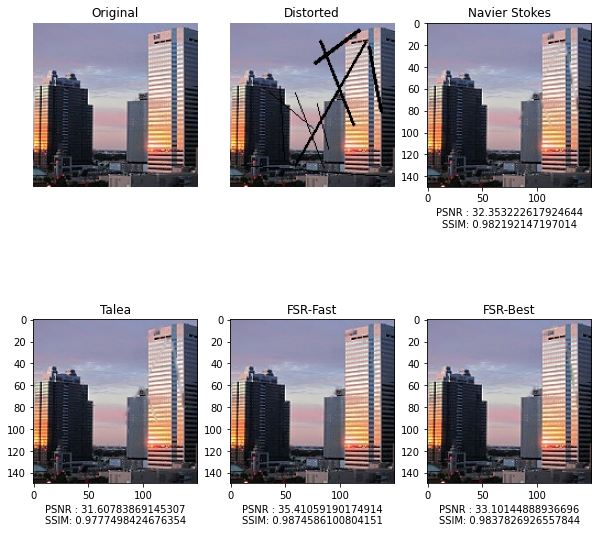

In [ ]:
i = 0

outputNS = cv2.inpaint(masked_image, mask_inp, 4, cv2.INPAINT_NS)
outputTelea = cv2.inpaint(masked_image, mask_inp, 4, cv2.INPAINT_TELEA)

outputFsrFast = masked_image.copy()
outputFsrBest = masked_image.copy()
cv2.xphoto.inpaint(masked_image, mask_inp_inv, outputFsrFast, cv2.xphoto.INPAINT_FSR_FAST)
cv2.xphoto.inpaint(masked_image, mask_inp_inv, outputFsrBest, cv2.xphoto.INPAINT_FSR_BEST)

dstFsrFast = cv2.cvtColor(outputFsrFast, cv2.COLOR_BGR2RGB)
dstFsrBest = cv2.cvtColor(outputFsrBest, cv2.COLOR_BGR2RGB)
dstNS = cv2.cvtColor(outputNS, cv2.COLOR_BGR2RGB)
dstTelea = cv2.cvtColor(outputTelea, cv2.COLOR_BGR2RGB)
dst = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)
img1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

psnrNS = cv2.PSNR(img, outputNS, 255)
ssimNS = SSIM(img, outputNS, multichannel=True)

psnrTelea = cv2.PSNR(img, outputTelea, 255)
ssimTelea = SSIM(img, outputTelea, multichannel=True)

psnrFsrFast = cv2.PSNR(img, outputFsrFast, 255)
ssimFsrFast = SSIM(img, outputFsrFast, multichannel=True)

psnrFsrBest = cv2.PSNR(img, outputFsrBest, 255)
ssimFsrBest = SSIM(img, outputFsrBest, multichannel=True)

plt.figure(figsize=(10, 10))

plt.subplot(2, 3, 1)
plt.imshow(img1)
plt.axis('Off')
plt.title('Original')

plt.subplot(2, 3, 2)
plt.imshow(dst)
plt.axis('Off')
plt.title('Distorted')

plt.subplot(2, 3, 3)
plt.imshow(dstNS)
plt.title('Navier Stokes')
plt.xlabel('PSNR : ' + str(psnrNS) + '\nSSIM: ' + str(ssimNS))

plt.subplot(2, 3, 4)
plt.imshow(dstTelea)
plt.title('Talea')
plt.xlabel('PSNR : ' + str(psnrTelea) + '\nSSIM: ' + str(ssimTelea))

plt.subplot(2, 3, 5)
plt.imshow(dstFsrFast)
plt.title('FSR-Fast')
plt.xlabel('PSNR : ' + str(psnrFsrFast) + '\nSSIM: ' + str(ssimFsrFast))

plt.subplot(2, 3, 6)
plt.imshow(dstFsrBest)
plt.title('FSR-Best')
plt.xlabel('PSNR : ' + str(psnrFsrBest) + '\nSSIM: ' + str(ssimFsrBest))

### GAN

In [28]:
class InpaintingModel:

  def define_gan(self, g_model, d_model, image_shape):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
      if not isinstance(layer, BatchNormalization):
        layer.trainable = False
    
    input_image = Input(shape=image_shape)
    input_mask = Input(shape=image_shape)

    # connect the source image to the generator input
    gen_out = g_model([input_image, input_mask])

    # connect the source input and generator output to the discriminator input
    dis_out = d_model([input_image, gen_out])

    # src image as input, generated image and classification output
    model = Model([input_image, input_mask], [dis_out, gen_out])
    
    return model

  def discriminator(self, input_size=(128,128,3)):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # source image input
    masked_image = Input(shape=input_size)
    # target image input
    inpainted_image = Input(shape=input_size)
    # concatenate images channel-wise
    merged = Concatenate()([masked_image, inpainted_image])
    # C64
    conv1 = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    relu1 = LeakyReLU(alpha=0.2)(conv1)
    # C128
    conv2 = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(relu1)
    bn2 = BatchNormalization()(conv2)
    relu2 = LeakyReLU(alpha=0.2)(bn2)
    # C256
    conv3 = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(relu2)
    bn3 = BatchNormalization()(conv3)
    relu3 = LeakyReLU(alpha=0.2)(bn3)
    # C512
    conv4 = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(relu3)
    bn4 = BatchNormalization()(conv4)
    relu4 = LeakyReLU(alpha=0.2)(bn4)
    # second last output layer
    conv5 = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(relu4)
    bn5 = BatchNormalization()(conv5)
    relu5 = LeakyReLU(alpha=0.2)(bn5)
    # patch output
    convout = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(relu5)
    patch_out = Activation('sigmoid')(convout)
    # define model
    model = Model([masked_image, inpainted_image], patch_out)
    
    return model

  def generator(self, input_size=(128,128,3), training = True):
    input_image = Input(input_size)
    input_mask = Input(input_size, name='encoder_input')
  
    conv1, mask1, conv2, mask2 = self.__encoder_layer(32, input_image, input_mask, ['conv1', 'conv2'], training, batchnorm = False)
    conv3, mask3, conv4, mask4 = self.__encoder_layer(64, conv2, mask2, ['conv3', 'conv4'], training)
    conv5, mask5, conv6, mask6 = self.__encoder_layer(128, conv4, mask4, ['conv5', 'conv6'], training)
    conv7, mask7, conv8, mask8 = self.__encoder_layer(256, conv6, mask6, ['conv7', 'encoder_output'], training)

    conv9, mask9, conv10, mask10 = self.__decoder_layer(256, 128, conv8, mask8, conv7, mask7, ['conv9', 'conv10'], training)
    conv11, mask11, conv12, mask12 = self.__decoder_layer(128, 64, conv10, mask10, conv5, mask5, ['conv11', 'conv12'], training)
    conv13, mask13, conv14, mask14 = self.__decoder_layer(64, 32, conv12, mask12, conv3, mask3, ['conv13', 'conv14'], training)
    conv15, mask15, conv16, mask16 = self.__decoder_layer(32, 3, conv14, mask14, conv1, mask1, ['conv15', 'decoder_output'], training)

    outputs = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv16)

    return Model(inputs=[input_image, input_mask], outputs=[outputs])
    
  def __encoder_layer(self, filters, in_layer, in_mask, names, training, batchnorm = True):
    conv1, mask1 = PConv2D(32, (3,3), strides=1, padding='same', name=names[0])([in_layer, in_mask])
    conv1 = keras.activations.relu(conv1)

    conv2, mask2 = PConv2D(32, (3,3), strides=2, padding='same', name=names[1])([conv1, mask1])
    if batchnorm:
      conv2 = BatchNormalization()(conv2, training=training)
    conv2 = keras.activations.relu(conv2)

    return conv1, mask1, conv2, mask2

  def __decoder_layer(self, filter1, filter2, in_img, in_mask, share_img, share_mask, names, training):
    up_img = UpSampling2D(size=(2,2))(in_img)
    up_mask = UpSampling2D(size=(2,2))(in_mask)
    concat_img = Concatenate(axis=3)([share_img, up_img])
    concat_mask = Concatenate(axis=3)([share_mask, up_mask])

    conv1, mask1 = PConv2D(filter1, (3,3), padding='same', name=names[0])([concat_img, concat_mask])
    conv1 = keras.activations.relu(conv1)

    conv2, mask2 = PConv2D(filter2, (3,3), padding='same', name=names[1])([conv1, mask1])
    conv2 = BatchNormalization()(conv2, training = training)
    conv2 = keras.activations.relu(conv2)

    return conv1, mask1, conv2, mask2

In [29]:
def metric_psnr(y_true, y_pred):

  val = tf.image.psnr(y_true, y_pred, 1)

  return val

def metric_ssim(y_true, y_pred):

  
  if(y_true.shape[1] == 8):
    val = 0
  else:
    val = tf.image.ssim(y_true, y_pred, 1)

  return val

def dice_coef(y_true, y_pred):
   y_true_f = keras.backend.flatten(y_true)
   y_pred_f = keras.backend.flatten(y_pred)
   intersection = keras.backend.sum(y_true_f * y_pred_f)
   return (2. * intersection) / (keras.backend.sum(y_true_f + y_pred_f))

In [30]:
keras.backend.clear_session()
img_shape = (128,128,3)
discriminator = InpaintingModel().discriminator(img_shape)
disc_opt = Adam(lr=0.0002, beta_1=0.5)
discriminator.compile(loss='binary_crossentropy', optimizer=disc_opt, loss_weights=[0.5])

generator = InpaintingModel().generator(img_shape)
gan_model = InpaintingModel().define_gan(generator, discriminator, img_shape)
gan_opt = Adam(lr=0.0002, beta_1=0.5)
gan_model.compile(loss=['binary_crossentropy', 'mae'], optimizer= gan_opt, loss_weights=[1,100], metrics = [metric_psnr, metric_ssim, dice_coef])
gan_model.summary()
#keras.utils.plot_model(model, show_shapes=True, dpi=60, to_file='model_v2.png')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_5 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_1 (Functional)           (None, 128, 128, 3)  1719971     ['input_4[0][0]',                
                                                                  'input_5[0][0]']          

In [31]:
def generate_real_samples(sample_masked, sample_og, patch_shape):
	
	# retrieve selected images
	X1, X2 = sample_masked, sample_og
	# generate 'real' class labels (1)
	y = K.ones((X1.shape[0], patch_shape, patch_shape, 1))
	return [X1, X2], y

def generate_fake_samples(g_model, sample_masked, sample_masks, patch_shape):
	# generate fake instance
	X = g_model.predict([sample_masked, sample_masks])
	# create 'fake' class labels (0)
	y = K.zeros((X.shape[0], patch_shape, patch_shape, 1))
	return [sample_masked, X], y

In [32]:
traingen = ImgInpaintingDataset(train_files)
valgen = ImgInpaintingDataset(val_files)
testgen = ImgInpaintingDataset(pred_files, shuffle = False)

In [33]:
batchsize = 32
image_size = (128,128,3)
n_epochs = 25
n_patch = 8
n_steps = len(traingen)
n_val_steps = len(valgen)

for epoch in range(n_epochs):

  
  progbar = generic_utils.Progbar(n_steps)

  for i in range(n_steps):

    sample_masked, sample_og, sample_masks = traingen[i]

    [X_masked, X_original], y_real = generate_real_samples(sample_masked, sample_og, n_patch)
    [X_masked, X_generated], y_fake = generate_fake_samples(generator, sample_masked, sample_masks,  n_patch)

    # update discriminator for real samples
    d_loss1 = discriminator.train_on_batch([X_masked, X_original], y_real)

    # update discriminator for generated samples
    d_loss2 = discriminator.train_on_batch([X_masked, X_generated], y_fake)

    gout = gan_model.train_on_batch(
        [sample_masked, sample_masks], [y_real, sample_og])
    
    progbar.add(1, values=[("dloss_real", d_loss1), ("dloss_fake", d_loss2), ("gloss1", gout[0]), ("gloss2", gout[1]), ("psnr", gout[5]),  ("ssim", gout[5]), ("dice", gout[7])])
  gan_model.save("./drive/MyDrive/gan_epoch" + str(epoch))
  #dice = 
  #for j in range(n_val_steps):
  #    val_masked, val_og, val_masks = valgen[i]
  #    out = gan_model.predict([val_masked, val_masks])
  #    print(out)






438/438 [==============================] - 289s 642ms/step - dloss_real: 0.0431 - dloss_fake: 0.0491 - gloss1: 20.5449 - gloss2: 5.0283 - psnr: 0.0648 - ssim: 0.0648 - dice: 0.3789
INFO:tensorflow:Assets written to: ./drive/MyDrive/gan_epoch0/assets
438/438 [==============================] - 281s 641ms/step - dloss_real: 0.0076 - dloss_fake: 0.0131 - gloss1: 15.8210 - gloss2: 6.2286 - psnr: 0.0138 - ssim: 0.0138 - dice: 0.4880
INFO:tensorflow:Assets written to: ./drive/MyDrive/gan_epoch1/assets
438/438 [==============================] - 282s 643ms/step - dloss_real: 0.0573 - dloss_fake: 0.0708 - gloss1: 14.4466 - gloss2: 4.6803 - psnr: 0.0578 - ssim: 0.0578 - dice: 0.4908
INFO:tensorflow:Assets written to: ./drive/MyDrive/gan_epoch2/assets
438/438 [==============================] - 281s 642ms/step - dloss_real: 0.0120 - dloss_fake: 0.0156 - gloss1: 13.7291 - gloss2: 4.9545 - psnr: 0.0235 - ssim: 0.0235 - dice: 0.5125
INFO:tensorflow:Assets written to: ./drive/MyDrive/gan_epoch3/assets


### RPCA

In [11]:
traingen = ImgInpaintingDataset(train_files)
valgen = ImgInpaintingDataset(val_files)
testgen = ImgInpaintingDataset(pred_files, shuffle = False)

In [13]:
def metric_psnr(y_true, y_pred):

  val = tf.image.psnr(y_true, y_pred, 1)

  return val

def metric_ssim(y_true, y_pred):

  
  if(y_true.shape[1] == 8):
    val = 0
  else:
    val = tf.image.ssim(y_true, y_pred, 1)

  return val

def dice_coef(y_true, y_pred):
   y_true_f = keras.backend.flatten(y_true)
   y_pred_f = keras.backend.flatten(y_pred)
   intersection = keras.backend.sum(y_true_f * y_pred_f)
   return (2. * intersection) / (keras.backend.sum(y_true_f + y_pred_f))

In [14]:
def image_LS(image, L_image, S_image, thres=0):
    
    fig, ax = plt.subplots(1,4,figsize=(16,6))
    ax[0].imshow(image.astype('uint8'))
    ax[0].set_title("Original image", fontsize = 16)
    ax[1].imshow(L_image.astype('uint8'))
    ax[1].set_title("Low rank matrix L", fontsize = 16)
    ax[2].imshow(np.abs(S_image).astype('uint8'))
    ax[2].set_title("Sparse matrix S", fontsize = 16);
    tmp = image*0.0
    tmp[(np.abs(S_image)>thres)] = image[(np.abs(S_image)>thres)]*1
    ax[3].imshow(tmp.astype('uint8'))
    ax[3].set_title("Filter image pixels with S!=0", fontsize = 16);


def s_tau(X, tau):
        """Shrinkage operator
            Sτ [x] = sign(x) max(|x| − τ, 0)
        """
        return np.sign(X)*np.maximum(np.abs(X)-tau,0)
    
def d_tau(X, mu):
        """Singular value thresholding operator
            Dτ (X) = USτ(Σ)V∗, where X = UΣV∗
        """
        # singular value decomposition
        u, s, vh = np.linalg.svd(X, full_matrices=False)

        # Shrinkage of singular values
        tau = 1.0/mu
        s = s[s>tau] - tau
        rank = len(s)
        # reconstruct thresholded 2D array
        return  np.dot(u[:, 0:rank] * s, vh[0:rank,:]), rank


def RobustPCA(M, tol, max_iter):
    
        size = M.shape
        
        # initialize S and Y (Lagrange multiplier)
        S = np.zeros(size)
        Y = np.zeros(size)

        # if lamb and mu are not set, set with default values
        mu = np.prod(size)/4.0/np.sum(np.abs(M))
        lamb = 1/np.sqrt(np.max(size))

        # Alternating update
        for i in range(max_iter):
            L, rank = d_tau(M-S+1.0/mu*Y, mu)
            S = s_tau(M-L+1.0/mu*Y, lamb/mu)

            # Calculate residuals
            residuals = M-L-S
            residuals_sum = np.sum(np.abs(residuals))

            # Check convergency
            if residuals_sum <= tol:
                break

            Y = Y + mu*residuals

        # Check if the fit is converged
        if residuals_sum > tol:
            print('Not converged!')
            print('Total error: %f, allowed tolerance: %f'%(residuals_sum, tol))
        else:
            print('Converged!')

        return L, S, rank



In [22]:
psnr_rpca = []
ssim_rpca = []
dice_rpca = []

for idx in range(len(testgen)):

    sample_masked, sample_og, sample_masks = traingen[idx]
    
    for j in range(32):
      
      masked_image = sample_masked[j]
      img = sample_og[j]

      #%%
      print("Robust PCA ...", idx);

      L_image = masked_image*0
      S_image = masked_image*0
      rank = [];

      for i in range(3):
          L_image[:,:,i] ,S_image[:,:,i], rnk = RobustPCA(masked_image[:,:,i], tol = 1, max_iter=1000)
          rank.append(rnk)

      outputRPCA = (L_image*255)

      psnrRPCA = cv2.PSNR(img, outputRPCA, 255)
      ssimRPCA = SSIM(img, outputRPCA, multichannel=True)
      diceRPCA = dice_coef(img.astype('float64'), outputRPCA.astype('float64'))

      psnr_rpca.append(psnrRPCA)
      ssim_rpca.append(ssimRPCA)
      dice_rpca.append(diceRPCA)

print("Avg PSNR : ", np.mean(np.array(psnr_rpca)))
print("Avg SSIM : ", np.mean(np.array(ssim_rpca)))
print("Avg dice : ", np.mean(np.array(dice_rpca)))

#image_LS(image*255, outputRPCA, S_image*255, thres=0)

Streaming output truncated to the last 5000 lines.
Converged!
Converged!
Robust PCA ... 275
Converged!
Converged!
Converged!
Robust PCA ... 275
Converged!
Converged!
Converged!
Robust PCA ... 275
Converged!
Converged!
Converged!
Robust PCA ... 275
Converged!
Converged!
Converged!
Robust PCA ... 275
Converged!
Converged!
Converged!
Robust PCA ... 275
Converged!
Converged!
Converged!
Robust PCA ... 275
Converged!
Converged!
Converged!
Robust PCA ... 275
Converged!
Converged!
Converged!
Robust PCA ... 275
Converged!
Converged!
Converged!
Robust PCA ... 275
Converged!
Converged!
Converged!
Robust PCA ... 275
Converged!
Converged!
Converged!
Robust PCA ... 275
Converged!
Converged!
Converged!
Robust PCA ... 275
Converged!
Converged!
Converged!
Robust PCA ... 275
Converged!
Converged!
Converged!
Robust PCA ... 275
Converged!
Converged!
Converged!
Robust PCA ... 275
Converged!
Converged!
Converged!
Robust PCA ... 275
Converged!
Converged!
Converged!
Robust PCA ... 275
Converged!
Converged!
Co

KeyboardInterrupt: ignored

In [23]:
print("Avg PSNR : ", np.mean(np.array(psnr_rpca)))
print("Avg SSIM : ", np.mean(np.array(ssim_rpca)))
print("Avg dice : ", np.mean(np.array(dice_rpca)))

Avg PSNR :  6.767311182707145
Avg SSIM :  0.0003180059438893738
Avg dice :  1.1551692546478656


## Cifar 10 Data

In [8]:
## Ref: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.
class createAugment(keras.utils.Sequence):
  'Generates data for Keras'
  def __init__(self, X, y, batch_size=32, dim=(32, 32), n_channels = 3, shuffle=True):
      'Initialization'
      self.batch_size = batch_size 
      self.X = X 
      self.y = y
      self.dim = dim
      self.n_channels = n_channels
      self.shuffle = shuffle
      
      self.on_epoch_end()

  def __len__(self):
      'Denotes the number of batches per epoch'
      return int(np.floor(len(self.X) / self.batch_size))

  def __getitem__(self, index):
      'Generate one batch of data'
      # Generate indexes of the batch
      indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

      # Generate data
      return self.__data_generation(indexes)

  def on_epoch_end(self):
      'Updates indexes after each epoch'
      self.indexes = np.arange(len(self.X))
      if self.shuffle:
          np.random.shuffle(self.indexes)

  def __data_generation(self, idxs):
    # X_batch is a matrix of masked images used as input
    X_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Masked image
    # y_batch is a matrix of original images used for computing error from reconstructed image
    y_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Original image
    m_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Mask

    ## Iterate through random indexes
    for i, idx in enumerate(idxs):
      image_copy = self.X[idx].copy()
  
      ## Get mask associated to that image
      masked_image, mask = self.__createMask(image_copy)
      
      X_batch[i,] = masked_image/255.
      y_batch[i] = self.y[idx]/255.
      m_batch[i] = mask/255.
      
    return X_batch, y_batch, m_batch

  def __createMask(self, img):
    ## Prepare masking matrix
    
    mask = np.full(img.shape, 255, np.uint8)
    for _ in range(np.random.randint(1, 10)):
      # Get random x locations to start line
      x1, x2 = np.random.randint(1, 32), np.random.randint(1, 32)
      # Get random y locations to start line
      y1, y2 = np.random.randint(1, 32), np.random.randint(1, 32)
      # Get random thickness of the line drawn
      thickness = np.random.randint(1, 3)
      # Draw black line on the white mask
      cv2.line(mask,(x1,y1),(x2,y2),(1,1,1),thickness)

    # Perforn bitwise and operation to mak the image
    masked_image = cv2.bitwise_and(img, mask)

    return masked_image, mask

In [9]:
## Cifar 10 Dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

x_val, y_val = x_train[:10000], y_train[:10000]
x_train, y_train = x_train[10000:], y_train[10000:]
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

170508288/170498071 [==============================] - 4s 0us/step
x_train shape: (40000, 32, 32, 3)
40000 train samples
10000 train samples
10000 test samples


In [10]:
## Prepare training and testing mask-image pair generator
traingen = createAugment(x_train, x_train)
valgen = createAugment(x_val, x_val)
testgen = createAugment(x_test, x_test, shuffle=False)

In [11]:
class InpaintingModel:

  def define_gan(self, g_model, d_model, image_shape):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
      if not isinstance(layer, BatchNormalization):
        layer.trainable = False
    
    input_image = Input(shape=image_shape)
    input_mask = Input(shape=image_shape)

    # connect the source image to the generator input
    gen_out = g_model([input_image, input_mask])

    # connect the source input and generator output to the discriminator input
    dis_out = d_model([input_image, gen_out])

    # src image as input, generated image and classification output
    model = Model([input_image, input_mask], [dis_out, gen_out])
    
    return model

  def discriminator(self, input_size=(128,128,3)):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # source image input
    masked_image = Input(shape=input_size)
    # target image input
    inpainted_image = Input(shape=input_size)
    # concatenate images channel-wise
    merged = Concatenate()([masked_image, inpainted_image])
    # C64
    conv1 = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    relu1 = LeakyReLU(alpha=0.2)(conv1)
    # C128
    conv2 = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(relu1)
    bn2 = BatchNormalization()(conv2)
    relu2 = LeakyReLU(alpha=0.2)(bn2)
    # C256
    conv3 = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(relu2)
    bn3 = BatchNormalization()(conv3)
    relu3 = LeakyReLU(alpha=0.2)(bn3)
    # C512
    conv4 = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(relu3)
    bn4 = BatchNormalization()(conv4)
    relu4 = LeakyReLU(alpha=0.2)(bn4)
    # second last output layer
    conv5 = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(relu3)
    bn5 = BatchNormalization()(conv5)
    relu5 = LeakyReLU(alpha=0.2)(bn5)
    # patch output
    convout = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(relu5)
    patch_out = Activation('sigmoid')(convout)
    # define model
    model = Model([masked_image, inpainted_image], patch_out)
    
    return model

  def generator(self, input_size=(128,128,3), training = True):
    input_image = Input(input_size)
    input_mask = Input(input_size, name='encoder_input')
  
    conv1, mask1, conv2, mask2 = self.__encoder_layer(32, input_image, input_mask, ['conv1', 'conv2'], training, batchnorm = False)
    conv3, mask3, conv4, mask4 = self.__encoder_layer(64, conv2, mask2, ['conv3', 'conv4'], training)
    conv5, mask5, conv6, mask6 = self.__encoder_layer(128, conv4, mask4, ['conv5', 'conv6'], training)
    conv7, mask7, conv8, mask8 = self.__encoder_layer(256, conv6, mask6, ['conv7', 'encoder_output'], training)

    conv9, mask9, conv10, mask10 = self.__decoder_layer(256, 128, conv8, mask8, conv7, mask7, ['conv9', 'conv10'], training)
    conv11, mask11, conv12, mask12 = self.__decoder_layer(128, 64, conv10, mask10, conv5, mask5, ['conv11', 'conv12'], training)
    conv13, mask13, conv14, mask14 = self.__decoder_layer(64, 32, conv12, mask12, conv3, mask3, ['conv13', 'conv14'], training)
    conv15, mask15, conv16, mask16 = self.__decoder_layer(32, 3, conv14, mask14, conv1, mask1, ['conv15', 'decoder_output'], training)

    outputs = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv16)

    return Model(inputs=[input_image, input_mask], outputs=[outputs])
    
  def __encoder_layer(self, filters, in_layer, in_mask, names, training, batchnorm = True):
    conv1, mask1 = PConv2D(32, (3,3), strides=1, padding='same', name=names[0])([in_layer, in_mask])
    conv1 = keras.activations.relu(conv1)

    conv2, mask2 = PConv2D(32, (3,3), strides=2, padding='same', name=names[1])([conv1, mask1])
    if batchnorm:
      conv2 = BatchNormalization()(conv2, training=training)
    conv2 = keras.activations.relu(conv2)

    return conv1, mask1, conv2, mask2

  def __decoder_layer(self, filter1, filter2, in_img, in_mask, share_img, share_mask, names, training):
    up_img = UpSampling2D(size=(2,2))(in_img)
    up_mask = UpSampling2D(size=(2,2))(in_mask)
    concat_img = Concatenate(axis=3)([share_img, up_img])
    concat_mask = Concatenate(axis=3)([share_mask, up_mask])

    conv1, mask1 = PConv2D(filter1, (3,3), padding='same', name=names[0])([concat_img, concat_mask])
    conv1 = keras.activations.relu(conv1)

    conv2, mask2 = PConv2D(filter2, (3,3), padding='same', name=names[1])([conv1, mask1])
    conv2 = BatchNormalization()(conv2, training = training)
    conv2 = keras.activations.relu(conv2)

    return conv1, mask1, conv2, mask2

In [12]:
def metric_psnr(y_true, y_pred):

  val = tf.image.psnr(y_true, y_pred, 1)

  return val

def metric_ssim(y_true, y_pred):

  
  if(y_true.shape[1] == 4):
    val = 0
  else:
    val = tf.image.ssim(y_true, y_pred, 1)

  return val

def dice_coef(y_true, y_pred):
   y_true_f = keras.backend.flatten(y_true)
   y_pred_f = keras.backend.flatten(y_pred)
   intersection = keras.backend.sum(y_true_f * y_pred_f)
   return (2. * intersection) / (keras.backend.sum(y_true_f + y_pred_f))

In [13]:
tf.compat.v1.enable_eager_execution()


In [14]:
keras.backend.clear_session()
img_shape = (32,32,3)
discriminator = InpaintingModel().discriminator(img_shape)
disc_opt = Adam(lr=0.0002, beta_1=0.5)
discriminator.compile(loss='binary_crossentropy', optimizer=disc_opt, loss_weights=[0.5])

generator = InpaintingModel().generator(img_shape)
gan_model = InpaintingModel().define_gan(generator, discriminator, img_shape)
gan_opt = Adam(lr=0.0002, beta_1=0.5)
gan_model.compile(loss=['binary_crossentropy', 'mae'], optimizer= gan_opt, loss_weights=[1,100], metrics = [metric_psnr, metric_ssim, dice_coef])
gan_model.summary()
#keras.utils.plot_model(model, show_shapes=True, dpi=60, to_file='model_v2.png')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 model_1 (Functional)           (None, 32, 32, 3)    1719971     ['input_4[0][0]',                
                                                                  'input_5[0][0]']                
                                                                                                  
 model (Functional)             (None, 4, 4, 1)      2771393     ['input_4[0][0]',          

In [15]:
def generate_real_samples(sample_masked, sample_og, patch_shape):
	
	# retrieve selected images
	X1, X2 = sample_masked, sample_og
	# generate 'real' class labels (1)
	y = K.ones((X1.shape[0], patch_shape, patch_shape, 1))
	return [X1, X2], y

def generate_fake_samples(g_model, sample_masked, sample_masks, patch_shape):
	# generate fake instance
	X = g_model.predict([sample_masked, sample_masks])
	# create 'fake' class labels (0)
	y = K.zeros((X.shape[0], patch_shape, patch_shape, 1))
	return [sample_masked, X], y

In [16]:
batchsize = 32
image_size = (32,32,3)
n_epochs = 25
n_patch = 4
n_steps = len(traingen)
n_val_steps = len(valgen)


for epoch in range(n_epochs):

  
  progbar = generic_utils.Progbar(n_steps)

  for i in range(n_steps):

    sample_masked, sample_og, sample_masks = traingen[i]

    [X_masked, X_original], y_real = generate_real_samples(sample_masked, sample_og, n_patch)
    [X_masked, X_generated], y_fake = generate_fake_samples(generator, sample_masked, sample_masks,  n_patch)

    # update discriminator for real samples
    d_loss1 = discriminator.train_on_batch([X_masked, X_original], y_real)

    # update discriminator for generated samples
    d_loss2 = discriminator.train_on_batch([X_masked, X_generated], y_fake)

    gout = gan_model.train_on_batch(
        [sample_masked, sample_masks], [y_real, sample_og])
    
    progbar.add(1, values=[("dloss_real", d_loss1), ("dloss_fake", d_loss2), ("gloss1", gout[0]), ("gloss2", gout[1]), ("psnr", gout[5]),  ("ssim", gout[5]), ("dice", gout[7])])
  gan_model.save("./drive/MyDrive/cifargan_epoch" + str(epoch))

  print("Validation")
  dice_val = []
  ssim_val = []
  psnr_val = []
  for j in range(n_val_steps):
      val_masked, val_og, val_masks = valgen[j]
      d, out = gan_model.predict([val_masked, val_masks])
      for i in range(batchsize):
      
        psnr = metric_psnr(val_og[i], out[i].astype('float64'))
        ssim = metric_ssim(val_og[i],  out[i].astype('float64'))
        dice = dice_coef(val_og[i], out[i].astype('float64'))

        ssim_val.append(ssim.numpy())
        psnr_val.append(psnr.numpy())
        dice_val.append(dice.numpy())
  
  print("Avg PSNR: " + str(np.mean(psnr_val)) + " Avg SSIM: " + str(np.mean(ssim_val)) + " Avg Dice: " + str(np.mean(dice_val)))


1250/1250 [==============================] - 197s 144ms/step - dloss_real: 0.0674 - dloss_fake: 0.0670 - gloss1: 16.0238 - gloss2: 4.6038 - psnr: 0.0718 - ssim: 0.0718 - dice: 0.5258
INFO:tensorflow:Assets written to: ./drive/MyDrive/cifargan_epoch0/assets
Validation
Avg PSNR: 18.853895 Avg SSIM: 0.6322862 Avg Dice: 0.5458820522393386
1250/1250 [==============================] - 178s 143ms/step - dloss_real: 0.0329 - dloss_fake: 0.0374 - gloss1: 12.9972 - gloss2: 4.1917 - psnr: 0.0471 - ssim: 0.0471 - dice: 0.6317
INFO:tensorflow:Assets written to: ./drive/MyDrive/cifargan_epoch1/assets
Validation
Avg PSNR: 19.64772 Avg SSIM: 0.648908 Avg Dice: 0.5602150832497963
1250/1250 [==============================] - 179s 143ms/step - dloss_real: 0.0093 - dloss_fake: 0.0158 - gloss1: 12.3555 - gloss2: 4.6675 - psnr: 0.0255 - ssim: 0.0255 - dice: 0.6815
INFO:tensorflow:Assets written to: ./drive/MyDrive/cifargan_epoch2/assets
Validation
Avg PSNR: 20.474829 Avg SSIM: 0.6935019 Avg Dice: 0.56283896

In [17]:
ssim_all = []
psnr_all = []
dice_all = []
print(len(testgen))
for idx in range(len(testgen)):

    test_masked, test_og, test_masks = testgen[idx]

    d, out = gan_model.predict([test_masked, test_masks])
    print(idx)
    for i in range(32):
      
      psnr = metric_psnr(test_og[i], out[i].astype('float64'))
      ssim = metric_ssim(test_og[i],  out[i].astype('float64'))
      dice = dice_coef(test_og[i], out[i].astype('float64'))

      ssim_all.append(ssim.numpy())
      psnr_all.append(psnr.numpy())
      dice_all.append(dice.numpy())

print("Avg PSNR : ", np.mean(np.array(psnr_all)))
print("Avg SSIM : ", np.mean(np.array(ssim_all)))
print("Avg dice : ", np.mean(np.array(dice_all)))




      

312
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
27

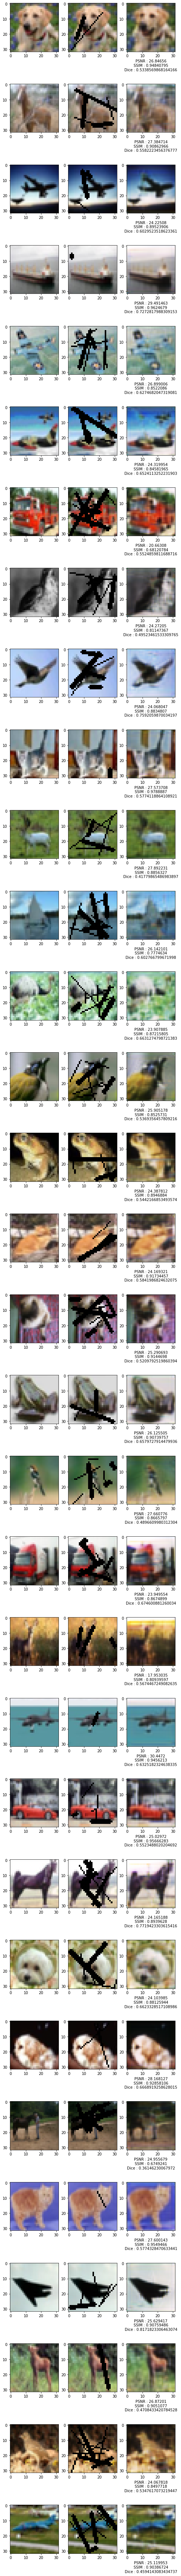

In [19]:
rows = 32
fig, axs = plt.subplots(nrows=rows, ncols=3, figsize=(8, 4*rows))

for i in range(rows):
  
  psnr = metric_psnr(test_og[i], out[i].astype('float64'))
  ssim = metric_ssim(test_og[i],  out[i].astype('float64'))
  dice = dice_coef(test_og[i], out[i].astype('float64'))
  axs[i][0].imshow(test_og[i])                                              # Ground truth
  axs[i][1].imshow(test_masked[i])                                              # Masked image
  axs[i][2].imshow(out[i])
  axs[i][2].set_xlabel("PSNR : " + str(psnr.numpy()) + "\nSSIM : " + str(ssim.numpy()) + "\nDice : " + str(dice.numpy()))

fig.savefig("./drive/MyDrive/cifargan_figure.pdf")

TypeError: ignored

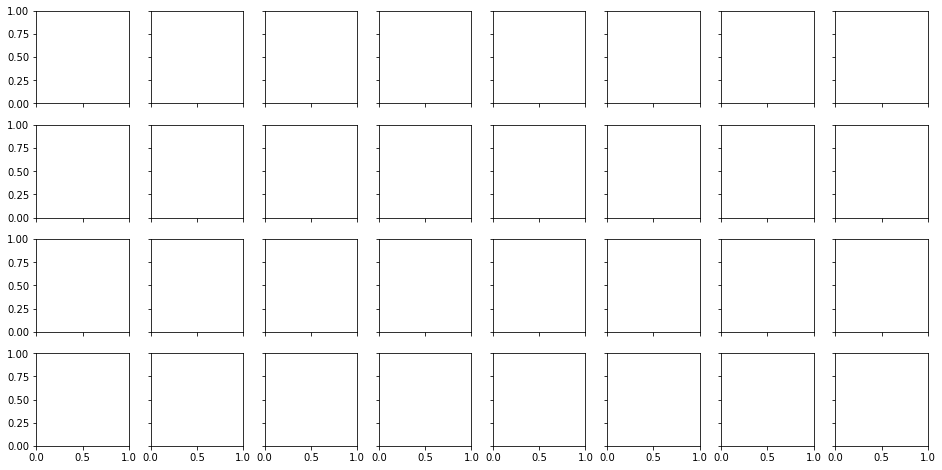

In [ ]:
## Examples
sample_idx = 90 ## Change this to see different batches

sample_masked, sample_og, sample_masks = traingen[sample_idx]
sample_masked = sample_masked.astype('uint8')
sample_masks = sample_masks.astype('uint8')
sample_og = sample_og.astype('uint8')
sample_images = [None]*(len(sample_masked)+len(sample_og))
sample_images[::2] = sample_masks
sample_images[1::2] = sample_masked

fig = plt.figure(figsize=(16., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image in zip(grid, sample_images):
  ax.imshow(image, cmap = 'gray')

plt.show()

In [ ]:
i = 2
masked_image = sample_masked[i]
img = sample_og[i]
mask_inp = cv2.cvtColor(sample_masks[i], cv2.COLOR_BGR2GRAY)
print(np.unique(mask_inp))
mask_inp[mask_inp != 1] = 0
print(np.unique(mask_inp))
mask_inp_inv = 1-mask_inp
print(np.unique(mask_inp_inv))

[  1 255]
[0 1]
[0 1]


Text(0.5, 0, 'PSNR : 18.98608593304385\nSSIM: 0.7801018817246151')

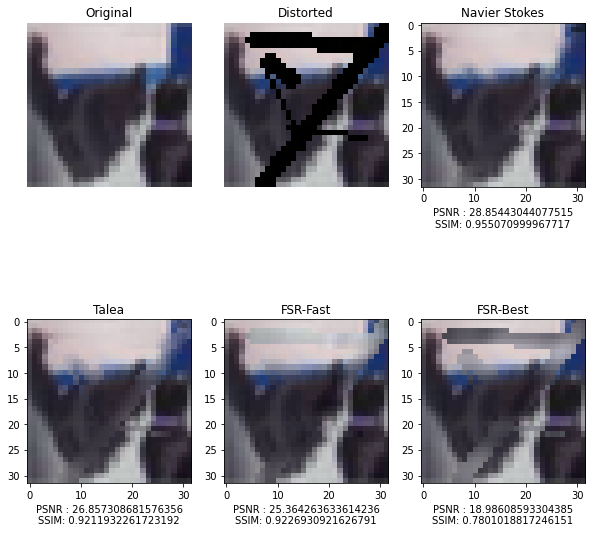

In [ ]:
outputNS = cv2.inpaint(masked_image, mask_inp, 4, cv2.INPAINT_NS)
outputTelea = cv2.inpaint(masked_image, mask_inp, 4, cv2.INPAINT_TELEA)

outputFsrFast = masked_image.copy()
outputFsrBest = masked_image.copy()
cv2.xphoto.inpaint(masked_image, mask_inp_inv, outputFsrFast, cv2.xphoto.INPAINT_FSR_FAST)
cv2.xphoto.inpaint(masked_image, mask_inp_inv, outputFsrBest, cv2.xphoto.INPAINT_FSR_BEST)

dstFsrFast = cv2.cvtColor(outputFsrFast, cv2.COLOR_BGR2RGB)
dstFsrBest = cv2.cvtColor(outputFsrBest, cv2.COLOR_BGR2RGB)
dstNS = cv2.cvtColor(outputNS, cv2.COLOR_BGR2RGB)
dstTelea = cv2.cvtColor(outputTelea, cv2.COLOR_BGR2RGB)
dst = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)
img1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

psnrNS = cv2.PSNR(img, outputNS, 255)
ssimNS = SSIM(img, outputNS, multichannel=True)

psnrTelea = cv2.PSNR(img, outputTelea, 255)
ssimTelea = SSIM(img, outputTelea, multichannel=True)

psnrFsrFast = cv2.PSNR(img, outputFsrFast, 255)
ssimFsrFast = SSIM(img, outputFsrFast, multichannel=True)

psnrFsrBest = cv2.PSNR(img, outputFsrBest, 255)
ssimFsrBest = SSIM(img, outputFsrBest, multichannel=True)

plt.figure(figsize=(10, 10))

plt.subplot(2, 3, 1)
plt.imshow(img1)
plt.axis('Off')
plt.title('Original')

plt.subplot(2, 3, 2)
plt.imshow(dst)
plt.axis('Off')
plt.title('Distorted')

plt.subplot(2, 3, 3)
plt.imshow(dstNS)
plt.title('Navier Stokes')
plt.xlabel('PSNR : ' + str(psnrNS) + '\nSSIM: ' + str(ssimNS))

plt.subplot(2, 3, 4)
plt.imshow(dstTelea)
plt.title('Talea')
plt.xlabel('PSNR : ' + str(psnrTelea) + '\nSSIM: ' + str(ssimTelea))

plt.subplot(2, 3, 5)
plt.imshow(dstFsrFast)
plt.title('FSR-Fast')
plt.xlabel('PSNR : ' + str(psnrFsrFast) + '\nSSIM: ' + str(ssimFsrFast))

plt.subplot(2, 3, 6)
plt.imshow(dstFsrBest)
plt.title('FSR-Best')
plt.xlabel('PSNR : ' + str(psnrFsrBest) + '\nSSIM: ' + str(ssimFsrBest))

In [ ]:
def image_LS(image, L_image, S_image, thres=0):
    
    fig, ax = plt.subplots(1,4,figsize=(16,6))
    ax[0].imshow(image.astype('uint8'))
    ax[0].set_title("Original image", fontsize = 16)
    ax[1].imshow(L_image.astype('uint8'))
    ax[1].set_title("Low rank matrix L", fontsize = 16)
    ax[2].imshow(np.abs(S_image).astype('uint8'))
    ax[2].set_title("Sparse matrix S", fontsize = 16);
    tmp = image*0.0
    tmp[(np.abs(S_image)>thres)] = image[(np.abs(S_image)>thres)]*1
    ax[3].imshow(tmp.astype('uint8'))
    ax[3].set_title("Filter image pixels with S!=0", fontsize = 16);


def s_tau(X, tau):
        """Shrinkage operator
            Sτ [x] = sign(x) max(|x| − τ, 0)
        """
        return np.sign(X)*np.maximum(np.abs(X)-tau,0)
    
def d_tau(X, mu):
        """Singular value thresholding operator
            Dτ (X) = USτ(Σ)V∗, where X = UΣV∗
        """
        # singular value decomposition
        u, s, vh = np.linalg.svd(X, full_matrices=False)

        # Shrinkage of singular values
        tau = 1.0/mu
        s = s[s>tau] - tau
        rank = len(s)
        # reconstruct thresholded 2D array
        return  np.dot(u[:, 0:rank] * s, vh[0:rank,:]), rank


def RobustPCA(M, tol, max_iter):
    
        size = M.shape
        
        # initialize S and Y (Lagrange multiplier)
        S = np.zeros(size)
        Y = np.zeros(size)

        # if lamb and mu are not set, set with default values
        mu = np.prod(size)/4.0/np.sum(np.abs(M))
        lamb = 1/np.sqrt(np.max(size))

        # Alternating update
        for i in range(max_iter):
            L, rank = d_tau(M-S+1.0/mu*Y, mu)
            S = s_tau(M-L+1.0/mu*Y, lamb/mu)

            # Calculate residuals
            residuals = M-L-S
            residuals_sum = np.sum(np.abs(residuals))

            # Check convergency
            if residuals_sum <= tol:
                break

            Y = Y + mu*residuals

        # Check if the fit is converged
        if residuals_sum > tol:
            print('Not converged!')
            print('Total error: %f, allowed tolerance: %f'%(residuals_sum, tol))
        else:
            print('Converged!')

        return L, S, rank

i = 2
masked_image = sample_masked[i]
img = sample_og[i]

image = masked_image/255

#%%
print("Robust PCA ...");

L_image = image*0
S_image = image*0
rank = [];

for i in range(3):
    L_image[:,:,i] ,S_image[:,:,i], rnk = RobustPCA(image[:,:,i], tol = 1, max_iter=1000)
    rank.append(rnk)

outputRPCA = (L_image*255).astype('uint8')

psnrRPCA = cv2.PSNR(img, outputRPCA, 255)
ssimRPCA = SSIM(img, outputRPCA, multichannel=True)

image_LS(image*255, outputRPCA, S_image*255, thres=0)

Robust PCA ...
Converged!
Converged!
Converged!


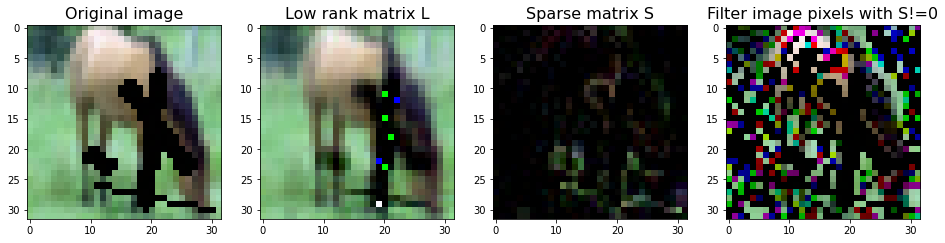

In [ ]:


print(psnrRPCA, ssimRPCA)

16.588118553201852 0.6855343140175426


In [ ]:
img.

dtype('uint8')

In [ ]:
L_image.dtype

dtype('float64')